# Portfolio optimization: mean-variance theory

* * *

In 1952, Harry Markowitz proposed a normative model on selection of risky assets. The basic assumption was that inversors care  about the **return** and **risk** of their portfolios. His great contribution was to define "return" as the mean of the probability distribution of assets returns and risk as the variance of that distribution.

By defining risk as variance, Markowitz was able to quantify precisely the gains of diversification: through diversification, risk can be reduced (though not eliminated) without changing the expected portfolio return.


In [1]:
import numpy as np
import pandas as pd

from matplotlib.ticker import FuncFormatter
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from numpy.random import multivariate_normal
import yfinance as yf

import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci

import statsmodels.api as sm

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

import functions as f

import random
random.seed(1000)

## Basic theory

### The expected return on a portfolio

The return of a risky asset j will be defined as

$$ R_{j,t,s} = \dfrac{P_{j,t,s} - P_{j,t-1}}{P_{j,t-1}}$$

Where P denotes the price of the asset, t-1 is the date in which the asset is bought, t is the date in which the asset is sold and s denote the state of nature.

For simplicity, we will asume that the return's distribution is discrete and $\pi_s$ is the probability  . Thus, its expectation equals:

$$E(R_{jt}) = \sum_{s = 1}^S \pi_s R_{jts}$$

Consider a portfolio consisting of N assets, and let $\omega_j$ be the weight of each asset in the cost of the portfolio, then the return of this portfolio is:

$$R_{p,t,s}  = \sum_{j=1}^N \omega_j R_{j,t,s}$$

That is, the return on a portfolio is a weithed average of the returns of the assets in the portfolio.

The portfolio's expected return is also the weigthed average of the asset expected returns:

$$E(R_p) = \sum_{j=1}^N\omega_jE(R_j)$$


### Measurement of risk and diversification

The variance of an asset return equals:

$$\sigma_j^2 = E [R_j - E(R_j)]^2 = \sum_{s=1}^S \pi_s [R_j - E(R_j)]^2$$

In order to understand how can a portfoolio reduce its risk through diversification, let's asume we only have two assets. The variance of this two-assets portfolio is:

$$ \sigma^2_p = \omega^2\sigma_1^2 + (1 - \omega)^2\sigma_2^2 + 2 \omega(1 - \omega)\sigma_{12}$$

$$ \sigma^2_p = \omega^2\sigma_1^2 + (1 - \omega)^2\sigma_2^2 + 2 \omega(1 - \omega)\rho_{12}\sigma_1\sigma_2$$

Note that the variance of the portfolio depends on the correlation between the assets. We will explore how different correlations have a different impact on the variance of the portfolio and therefore in diversification gains.


The entire model is described by mean and variance of the assets. Therefore we are necessarily assuming that no other statistics are necessary to describe the distribution of end-of-period wealth. 
Since normal distribution is determined by mean and variance, if returns are normal distributed then we can fully describe the investment opportunity set. We will need to verify this condition and in case it doesn't hold we will have to assume so.

We define the **invesment opportunity set** as the pairs of mean and standar deviarion that can be achived by inversing arbitrary amounts in the N risky assets. The **frontier** of the invesment opportunity set is defined as the set of portfolios with minimum variance among all portfolios with equal expected returns.


### Sharpe ratio

In order to be capable to compare between different investment choices, we need a risk-adjusted return measure. Sharpe ratio is defined as the excess portfolio return over the risk-free rate relative to its standard deviation:

$$ S = \dfrac{E(R_p) - R_f}{\sigma_p}$$

where $R_f$ is the risk free rate of the market.

### Different correlations

Supose we have 2 normaly distributed assets.  We want to explore how different correlation can generate different results in terms of diversification gains.

Recall the variance of the portfolio is


$$ \sigma^2_p = \omega^2\sigma_1^2 + (1 - \omega)^2\sigma_2^2 + 2 \omega(1 - \omega)\rho_{12}\sigma_1\sigma_2$$

Let's asume for simplicity that both assets have the same variance. Then,

$$ \sigma^2_p = \left[1 - 2\omega(1 - \omega)(1 - \rho_{12})\right]\sigma^2$$

This allows as to visualize the reduction of the portfolio variance compared to the variance of the assets, i.e. diversification gains.



#### Case 1: Uncorrelated returns ($\rho =0$)

The maximum reduction in variance is achived when the inversment is equally split across securities ($\omega = 1/2$), which gives:

$$ \sigma^2_p = [1 - 2\omega(1 - \omega)]\sigma^2$$

$$\sigma^2_p = \left[1 - \dfrac{1}{2}\right]\sigma^2  = \dfrac{1}{2}\sigma^2$$

This means that by combining the two assets, variance can be reduced to half of individual variances. 
This makes very sense if we think of what a zero correlation means. Think for instance of tossing a coin twice, where the outcome of each toss is independent of the other. If instead of betting everything on a single toss we split out money into two toss, some losses will be offset by gains on the other gamble, but we may still lose on boths. Risk is reduced but not eliminated.

We will set the same variances for both assets and equal to 1. This will imply that $\rho_{1,2} = \dfrac{cov_{12}}{var_1 var_2} = cov_{12}$. Let's also assume that the assets means are 1 and 2.

In [54]:
def rand_weights(n):
    k = np.random.rand(n)
    return k / sum(k)

def portf_mean(w, mean):
    mu = w.dot(mean)
    return mu
    
def portf_var(w, cov_matrix):
    
    sigma = np.diagonal(w.dot(cov_matrix).dot(w.T))
    return sigma    

In [55]:
weights = np.zeros((500,2))
for i in range(len(weights)):
    weights[i] = f.rand_weights(2)

In [56]:
var1 = 1
var2 = 1
var= [var1, var2]
mean = [1,2]

In [57]:
def mean_var_plot(mean, var, corr):
    fig = plt.figure(figsize = (22,9))              
    plt.scatter(var, mean, marker='o',alpha = 0.8, label = 'Efficient part of the frontier')
    
    if corr == 1:
        for mu, sigma in zip(mean, var):
            if mu < max(mean):
                plt.scatter(sigma, mu, color = 'tomato')
        plt.scatter(x= var[np.argmax(mean)], y = max(mean), 
                    lw = 8, label = 'Minimum variance achieved',  marker= "X", c ='gold', s=70)

    else:
        for mu, sigma in zip(mean, var):
            if mu < mean[np.argmin(var)]:
                plt.scatter(sigma, mu, color = 'tomato')
        plt.scatter(x= min(var), y = mean[np.argmin(var)], marker= "X",
                   lw = 8, label = 'Minimum variance achieved', c ='gold', s=70)                
            
    plt.xlabel('Variance', fontsize = 15)
    plt.ylabel('Mean', fontsize = 15)
    plt.xlim(-0.01)
    plt.legend(loc='lower left', fontsize = 15)
    plt.title('Mean-variance frontiers for two asset with correlation '+ str(corr), fontsize = 17)
    plt.grid(True)
    
    return

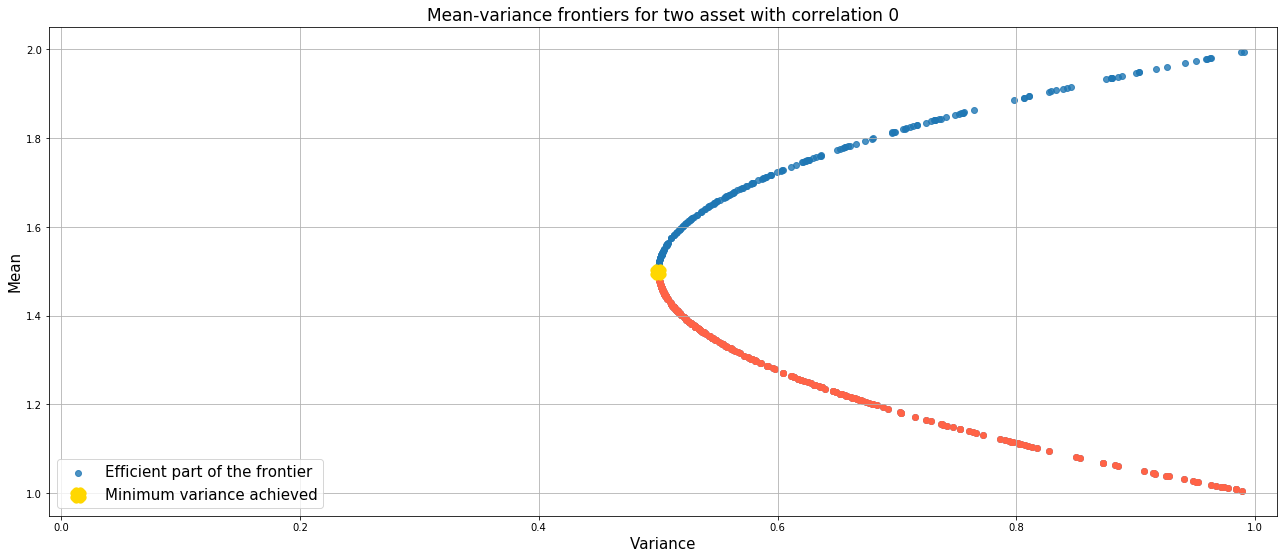

In [58]:
#Case 1
cov1 = 0
cov_matrix1 = np.asarray([[var1, cov1],
              [cov1, var2]])
case1 = multivariate_normal(mean, cov_matrix1, size = 100)
mean_p1= f.portf_mean(weights, mean)
var_p1 = f.portf_var(weights, cov_matrix1)

mean_var_plot(mean_p1, var_p1, corr = 0)

#### Case 2: Imperfectly positively correlated returns ($\rho =0.5$)

$$ \sigma^2_p = [1 - \omega(1 - \omega)]\sigma^2$$

Again, the maximum reduction in variance is achieved when the investment is equally split aross assets, but now:

$$ \sigma^2_p = \left[1 - \dfrac{1}{4}\right]\sigma^2 = \dfrac{3}{4}\sigma^2$$

Only a quarter of individual variance can be reduced. Losses are offset by gains but assets returns tend to move in the same direction, so such compensations across assets are less frequent.


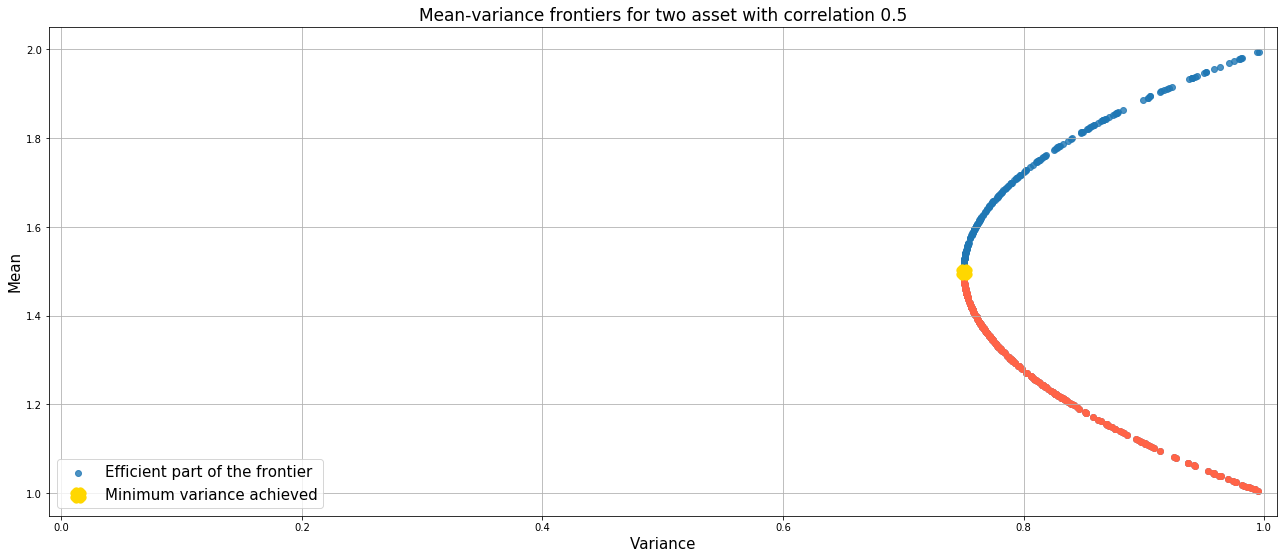

In [59]:
#Case 2
cov2 = 0.5
cov_matrix2 = [[var1, cov2],
              [cov2, var2]]
case2 = multivariate_normal(mean, cov_matrix2, size = 100)
mean_p2= f.portf_mean(weights, mean)
var_p2 = f.portf_var(weights,cov_matrix2)

mean_var_plot(mean_p2, var_p2, corr = 0.5)

#### Case 3: Perfectly positively correlated returns ($\rho = 1$)

$$ \sigma^2_p = [1 - 2\omega(1 - \omega)(1-1)]\sigma^2 = \sigma^2$$

Since assets always move in the same direction, there is no diversification gains.


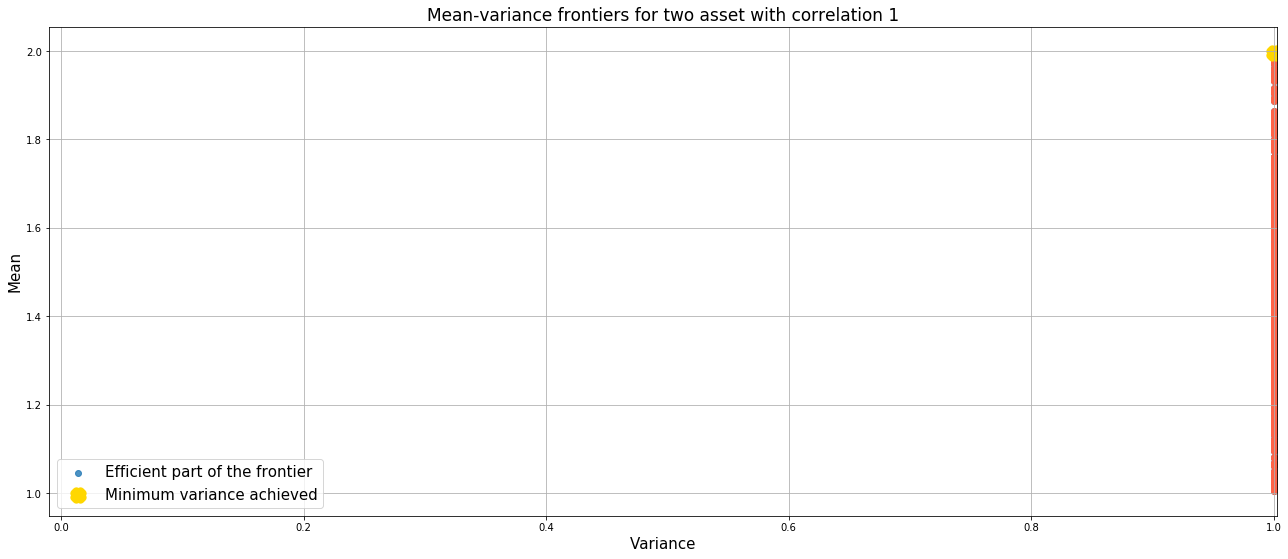

In [60]:
#Case 3
cov3 = 1
cov_matrix3 = [[var1, cov3],
              [cov3, var2]]
case3 = multivariate_normal(mean, cov_matrix3, size = 100)
mean_p3= f.portf_mean(weights, mean)
var_p3 = f.portf_var(weights, cov_matrix3)

mean_var_plot(mean_p3, var_p3, corr = 1)

#### Case 4: Imperfectly negatively correlated returns  ($\rho = -0.5$)

$$ \sigma^2_p = [1 - 3\omega(1 - \omega)]\sigma^2 $$

With $\omega = 1/2$:

$$ \sigma^2_p = \left[1 - \dfrac{3}{4}\right]\sigma^2 = \dfrac{1}{4}\sigma^2$$

Losses on one asset are offset by gains on the other. This happens more frequently than in the no correlation case, as asset returns tend to move in opposite directions.


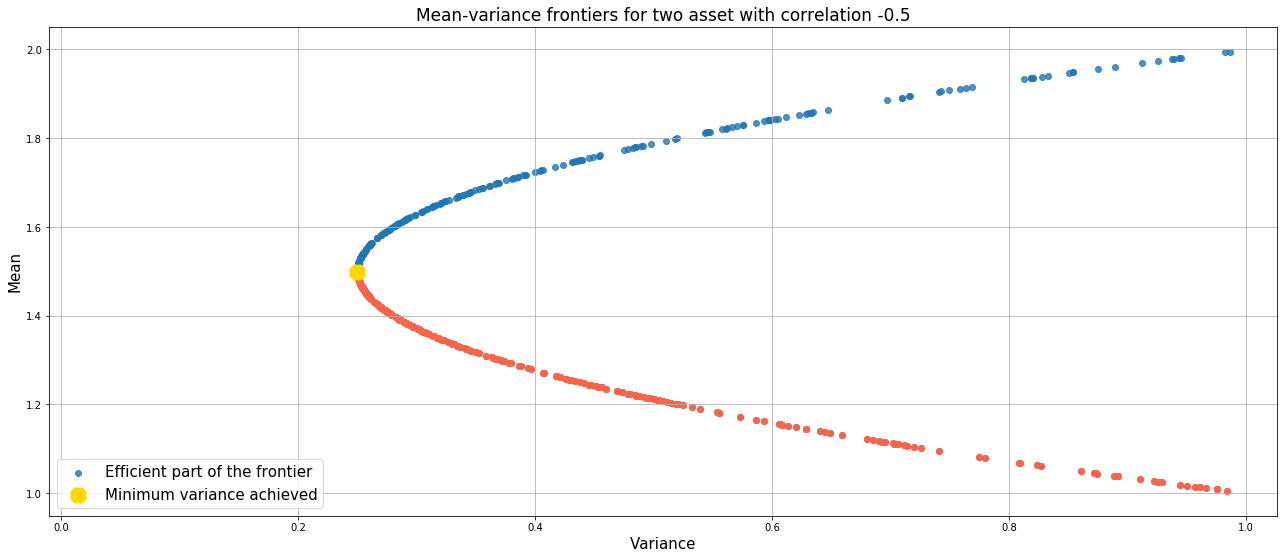

In [61]:
#Case 4
cov4 = -0.5
cov_matrix4 = [[var1, cov4],
              [cov4, var2]]
case4 = multivariate_normal(mean, cov_matrix4, size = 100)
mean_p4= f.portf_mean(weights, mean)
var_p4 = f.portf_var(weights, cov_matrix4)

mean_var_plot(mean_p4, var_p4, corr = -0.5)

#### Case 5: Perfectly negatively correlated returns ($\rho = -1$)

$$ \sigma^2_p = [1 - 4\omega(1 - \omega)(1-1)]\sigma^2$$

Setting $\omega = 1/2$ we get:

$$ \sigma^2_p = \left[1 - \dfrac{4}{4}\right]\sigma^2 = 0 $$

In this case losses are always compensated with gains so we can completely eliminate variance. Instead of risk diversification, we are actually talking about *risk hedging*. 

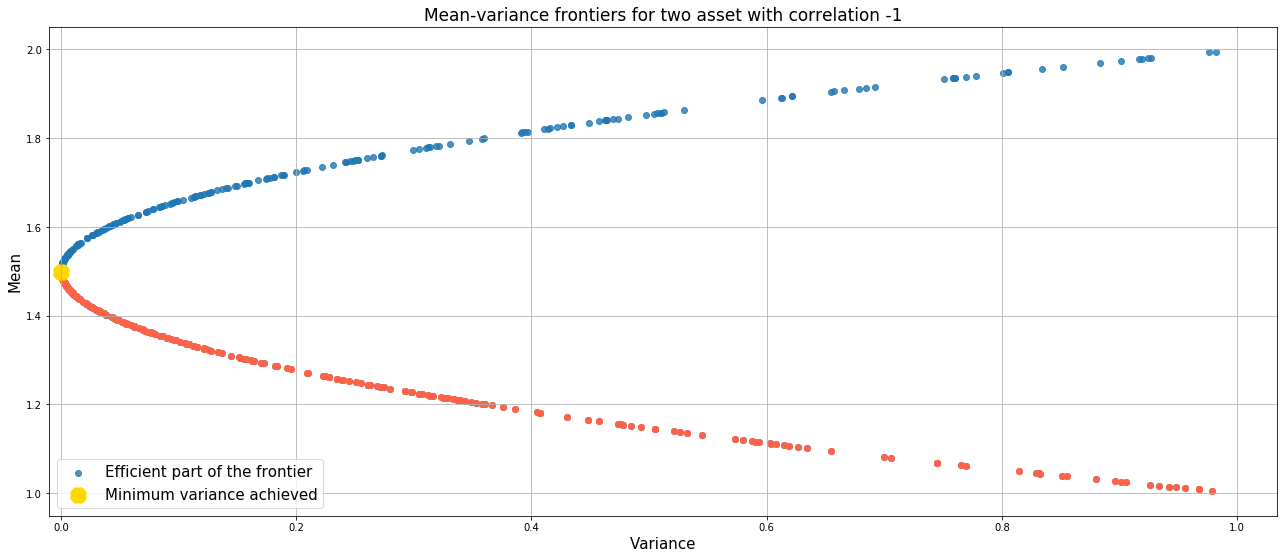

In [62]:
#Case 5
cov5 = -1
cov_matrix5 = [[var1, cov5],
              [cov5, var2]]
case5 = multivariate_normal(mean, cov_matrix5, size = 100)
mean_p5= f.portf_mean(weights, mean)
var_p5 = f.portf_var(weights, cov_matrix5)

mean_var_plot(mean_p5, var_p5, corr = -1)

Text(0.5, 1.0, 'Mean-variance frontiers for different correlations')

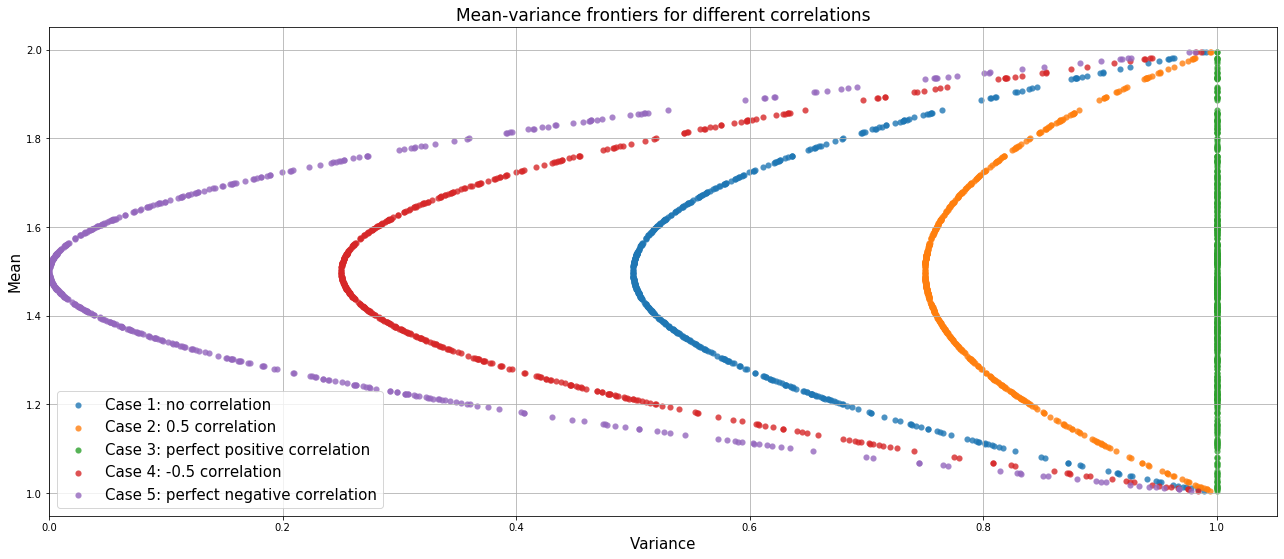

In [63]:
fig = plt.figure(figsize = (22,9))              
plt.scatter(var_p1, mean_p1, marker='o', lw = 0.1, alpha = 0.8, label = 'Case 1: no correlation')
plt.scatter(var_p2, mean_p2, marker='o', lw = 0.1, alpha = 0.8, label = 'Case 2: 0.5 correlation') 
plt.scatter(var_p3, mean_p3, marker='o', lw = 0.1, alpha = 0.8, label = 'Case 3: perfect positive correlation') 
plt.scatter(var_p4, mean_p4, marker='o', lw = 0.1, alpha = 0.8, label = 'Case 4: -0.5 correlation') 
plt.scatter(var_p5, mean_p5, marker='o', lw = 0.1, alpha = 0.8, label = 'Case 5: perfect negative correlation') 

plt.xlabel('Variance', fontsize = 15)
plt.ylabel('Mean', fontsize = 15)
plt.xlim(0)
plt.legend(loc='lower left', fontsize = 15)
plt.grid(True)
plt.title('Mean-variance frontiers for different correlations', fontsize = 17)

In [64]:
def returns_plot(cov):
    cov_matrix = np.asarray([[1, cov],
              [cov, 1]])
    mean = [0,0]
    case = multivariate_normal(mean, cov_matrix, size = 1000)
    
    fig = plt.figure(figsize = (10,7))
    
    plt.scatter(x=case[:,0], y=case[:,1])
    plt.xlabel('Asset 1 returns')
    plt.ylabel('Asset 2 returns')
    plt.title('Scatter plot of assets returns with correlation '+ str(cov))
    plt.xlim(-4,4)
    plt.grid(True)
    
    return 

Correlation: .87


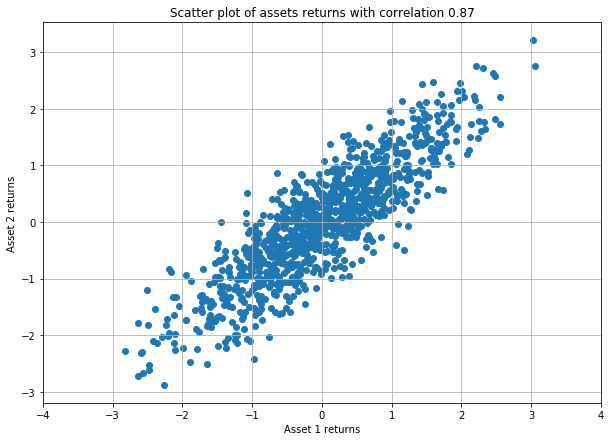

In [65]:
cor = float(input("Correlation: "))
if cor> 1 or cor< -1:
    print('Error! Correlation must be between -1 and 1')
else:
    returns_plot(cor)
    

Let's now add a third asset.

In [69]:
weights = np.zeros((2000,3))
for i in range(len(weights)):
    weights[i] = f.rand_weights(3)

In [75]:
noa = 3
n_obs = 10000

return_vec = np.random.randn(noa, n_obs)

array([[ 1.0256258 , -0.00795447, -0.01297503],
       [-0.00795447,  0.99984378,  0.01414358],
       [-0.01297503,  0.01414358,  0.99459392]])

''

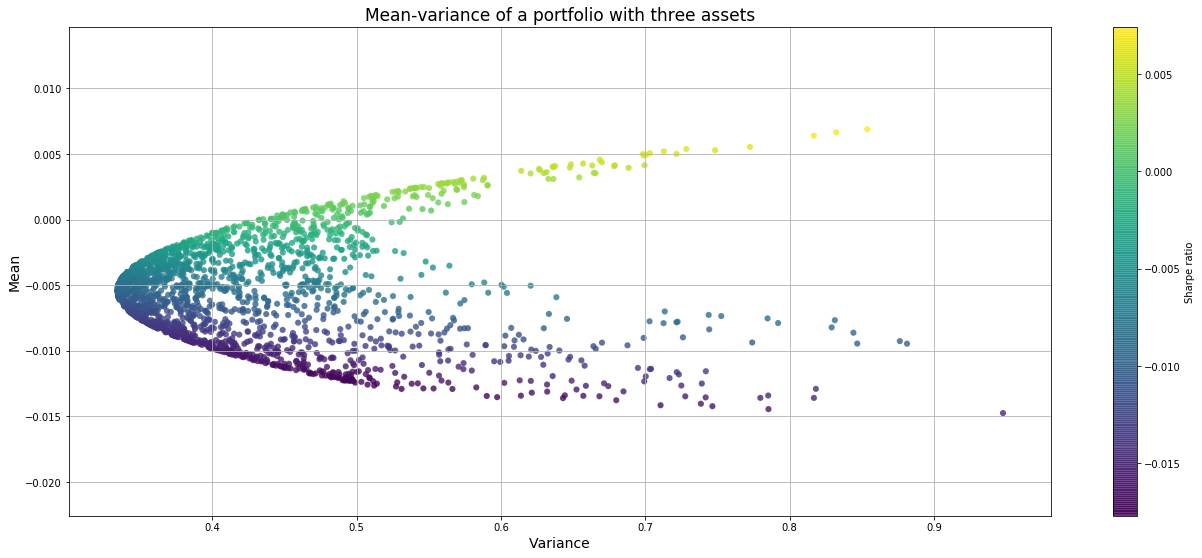

In [76]:
pmean= f.portf_mean(weights, np.mean(return_vec, axis = 1))
pvar = f.portf_var(weights, np.cov(return_vec))


fig = plt.figure(figsize = (22,9))          
plt.scatter(pvar, pmean, marker='o', lw = 0.1, alpha = 0.8, c = pmean/np.sqrt(pvar))
plt.grid(True)
plt.title('Mean-variance of a portfolio with three assets', fontsize = 17)
plt.xlabel('Variance', fontsize = 14)
plt.ylabel('Mean', fontsize = 14)
plt.colorbar(label = 'Sharpe ratio')
;

The graph above shows that when we invest in the three assets simultaneously, not only do we have access to mere combination of mean and variance, but also to better combinations. By adding a third asset to the portfolio, we profit from further diversification gains.

When calculating the Shapre ratio we assume $R_f = 0$

## Efficient frontier

*We will explain in detail the steps for finding the efficient frontier later.*

In [77]:
bnds = tuple((0, 1) for x in range(noa))

def min_func_port(w):
    return statistics(w)[1]

def statistics(weights):
    
    weights = np.array(weights) 
    pret = np.sum(np.mean(return_vec, axis = 1) * weights)
    pvol = np.dot(weights, np.dot(np.cov(return_vec), weights.T))
    
    return np.array([pret, pvol, pret / pvol])

trets = np.linspace(pmean.min(), pmean.max(), 100)
tvols = []

ef_we = []

for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret}, 
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, [noa * [1. / noa,]], method='SLSQP',  
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
    ef_we.append(res['x'].round(3))
       
tvols = np.array(tvols)

ind = np.argmin(tvols)
tvols = tvols[ind:]
trets = trets[ind:]

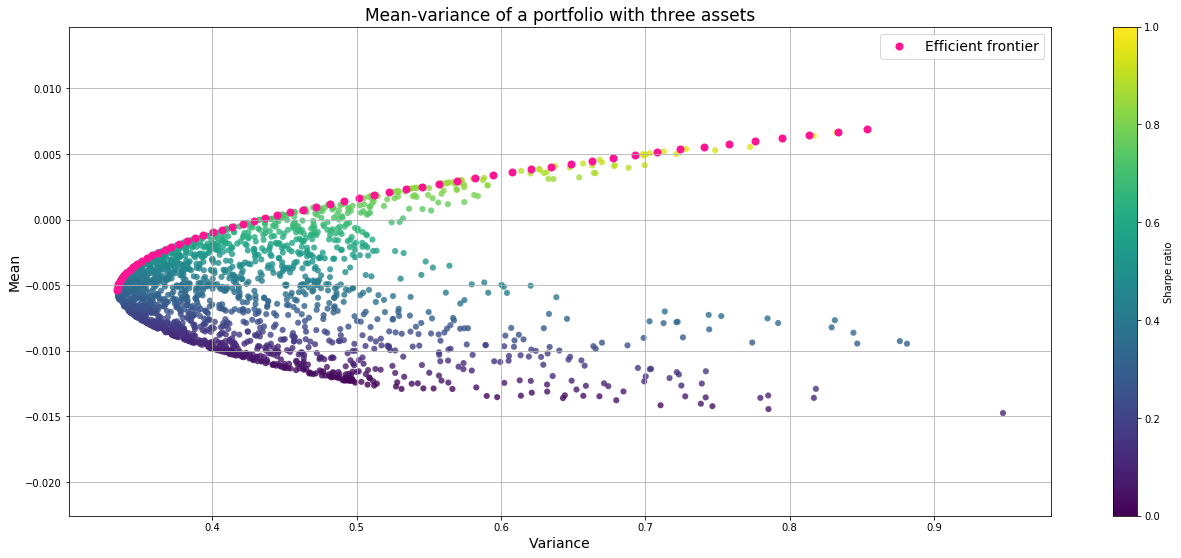

In [78]:
fig = plt.figure(figsize = (22,9))          
plt.scatter(pvar, pmean, marker='o', lw = 0.1, alpha = 0.8, c = pmean/np.sqrt(pvar))
plt.scatter(tvols, trets, c = 'deeppink', marker='o', label='Efficient frontier', lw = 2)
x = np.linspace(0.0, 5)

plt.grid(True)
plt.title('Mean-variance of a portfolio with three assets', fontsize = 17)
plt.xlabel('Variance', fontsize = 14)
plt.ylabel('Mean', fontsize = 14)
plt.colorbar(label = 'Sharpe ratio')
plt.legend(loc='best', fontsize = 14)

## Real data

In [2]:
tickers_funds =['IAU','TLH','LQD','HYG','^GSPC','EFA','EEM','VNQ','DX-Y.NYB','EURUSD=X']

data = pd.DataFrame(columns=tickers_funds)

for ticker in tickers_funds:
    data[ticker] = yf.download(ticker, period='10y')['Adj Close']
    
tickers_labels = ['Gold','iShares US Treas 10y-20y','iShares IG Corp',
                  'iShares HY Corp','S&P 500','iShares MSCI EAFE','iShares MSCI EM',
                  'Vanguard Real Estate Index', 'US Dollar/USDX - Index','EURUSD=X']

data.columns = tickers_labels
data = data.dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
data.head()

Gold  iShares US Treas 10y-20y  iShares IG Corp  iShares HY Corp  \
Date                                                                            
2010-10-18  13.44                 97.151924        78.697136        50.521709   
2010-10-19  13.04                 97.417137        78.704155        50.516075   
2010-10-20  13.14                 97.513550        78.844498        50.673737   
2010-10-21  12.97                 96.854584        78.634018        50.594936   
2010-10-22  12.98                 96.926918        78.732231        50.825794   

                S&P 500  iShares MSCI EAFE  iShares MSCI EM  \
Date                                                          
2010-10-18  1184.709961          42.847408        37.963356   
2010-10-19  1165.900024          41.903664        36.761257   
2010-10-20  1178.170044          42.691349        37.346062   
2010-10-21  1180.260010          42.460995        37.346062   
2010-10-22  1183.079956          42.572453        37.386677   

            Vanguard Real Estate Index  US Dollar/USDX - Index  EURUSD=X  
Date                                                                      
2010-10-18                   36.954472               76.930000  1.396433  
2010-10-19                   36.498318               78.180000  1.393592  
2010-10-20                   37.296577               77.169998  1.373909  
2010-10-21                   37.256332               77.419998  1.396317  
2010-10-22                   37.276436               77.470001  1.391692

Since time series start at rather different absolute value, we can show them in direct comparision by normalizing the, to a starting value of 100:

In [10]:
fig = px.line(data/ data.iloc[0] * 100)
fig.update_layout( title= "Last 10 years assets evolution",
            xaxis_title="Date",
            yaxis_title="Value",
            font=dict(
                family="Arial, monospace",
                size=12,
                color="black"
            ))
fig.show()

Let's now calculate log returns as   $ \log (P_t / P_{t-1})$ and analyse if they can be considered as normally distributed by observing their histograms and some other statistics, particularly Skewness and Kurtosis.

But first, let us introduce some statistical concepts.


### Random variables and probability functions

A **random variable** is a function that maps the outcomes of random phenomena to a unique numerical value.

The function that relates outcomes to their probabilities is called **probability density function (PDF)**

The **distribution function** shows the probability of receiving an outcome or  a lower one, that is, it shows the cumulative probabilities.

Let $X$ be a random variable, $q$ certain realization of that random variable, $f(x)$ the probability density function and $F(x)$ the distribution probability, then the probability that $X \leq q$ is:

$$ F(q) = \int_{-\infty}^{q}f(x)dx$$


#### Normal distribution
The normal distribution is the most commonly used distribution mainly beacuse is more convenient to work with than most other distributions, and it is completely described by the first and second moments.

$X$ is normally distributed if it has the density:

$$ f(x; \mu, \sigma) = \dfrac{1}{\sqrt{2\pi}\sigma} \exp \left[ - \dfrac{1}{2} \left( \dfrac{x - \mu}{\sigma}\right)^2\right]$$

and we write $X \sim N (\mu , \sigma^2)$

The normal distribution is unimiodal, symmetric and centered on $\mu$. The variance, $\sigma^2$, governs the dispertion of the distribution.

**Standard normal distribution**: Is the name given to the normal distribution with mean zero and unit variance, that is: $X \sim N (0,1) $

### Moments of a random variable

**Expectation**

The expectation of $X$, $\mu$, is the expected value or mean of the variable. It is defined by:

$$\mu = E(X) = \int_{-\infty}^{\infty}x f(x) dx$$

and it is estimated by the sample mean:

$$ \hat{\mu} = \hat{x} = \dfrac{1}{N}\sum_{i=1}^Nx_i$$


**Variance**

The variance of $X$ measures the spread of the variable around its mean. It is defined by:

$$\sigma^2 = E \left[ (X - \mu)^2\right] = \int_{-\infty}^{\infty}(x - \mu)^2 f(x) dx$$

If $\mu$ is known, we can compute the sample variance by:

$$\hat{\sigma}^2= \dfrac{1}{N}\sum_{i=1}^N (x_i - \mu)^2$$

In the more realistic case, in which $\mu$ is unknown we have to use the sample mean and adjust the formula in order to find the unbiased estimator for $\sigma^2$:

$$\hat{\sigma}^2= \dfrac{1}{N-1}\sum_{i=1}^N (x_i - \hat{\mu})^2$$


#### Higher order moments:

The mth moment of a random variable $X$ is defined by:
$$E(X^m)$$

and the mthe centered moment of a random variable is defined by:
$$E\left[ (X - \mu) ^m \right]$$.

Note that the first centered moment is the meand and the second centered moment is the variance.
*Skewness* and *Kurtosis* are functions of the third and fourth moments.


**Skewness**:
It is a measure of the asymmetry of the probability distribution of a random variable about its mean. In other words, skewness tells you the amount and direction of skew (departure from horizontal symmetry). The skewness value can be positive or negative, or even undefined. If skewness is 0, the data are perfectly symmetrical, although it is quite unlikely for real-world data. As a general rule of thumb:

 - If skewness is less than -1 or greater than 1, the distribution is highly skewed.
 - If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.
 - If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

**Kurtosis**: 
This statistic tells you the height and sharpness of the central peak, relative to that of a standard bell curve.

 - If the kurtosis is 3, the distribution is normal.
 - If the kurtosis is less than 3, the distribution is platykurtic.
 - If the kurtosis is greater than 3, the distribution is leptokurtic.

In [3]:
log_returns = np.log(data / data.shift(1))
log_returns = np.round(log_returns.dropna(),4)
log_returns

Gold  iShares US Treas 10y-20y  iShares IG Corp  \
Date                                                            
2010-10-19 -0.0302                    0.0027           0.0001   
2010-10-20  0.0076                    0.0010           0.0018   
2010-10-21 -0.0130                   -0.0068          -0.0027   
2010-10-22  0.0008                    0.0007           0.0012   
2010-10-25  0.0100                    0.0025           0.0036   
...            ...                       ...              ...   
2020-10-12 -0.0027                    0.0026           0.0058   
2020-10-13 -0.0170                    0.0052          -0.0010   
2020-10-14  0.0033                    0.0015           0.0010   
2020-10-15  0.0039                   -0.0010          -0.0010   
2020-10-16  0.0014                   -0.0003           0.0012   

            iShares HY Corp  S&P 500  iShares MSCI EAFE  iShares MSCI EM  \
Date                                                                       
2010-10-19          -0.0001  -0.0160            -0.0223          -0.0322   
2010-10-20           0.0031   0.0105             0.0186           0.0158   
2010-10-21          -0.0016   0.0018            -0.0054           0.0000   
2010-10-22           0.0046   0.0024             0.0026           0.0011   
2010-10-25           0.0039   0.0021             0.0038           0.0108   
...                     ...      ...                ...              ...   
2020-10-12           0.0050   0.0163             0.0058           0.0087   
2020-10-13          -0.0045  -0.0063            -0.0113          -0.0041   
2020-10-14          -0.0025  -0.0066            -0.0017          -0.0068   
2020-10-15          -0.0007  -0.0015            -0.0119          -0.0072   
2020-10-16           0.0014   0.0056             0.0063           0.0041   

            Vanguard Real Estate Index  US Dollar/USDX - Index  EURUSD=X  
Date                                                                      
2010-10-19                     -0.0124                  0.0161   -0.0020  
2010-10-20                      0.0216                 -0.0130   -0.0142  
2010-10-21                     -0.0011                  0.0032    0.0162  
2010-10-22                      0.0005                  0.0006   -0.0033  
2010-10-25                      0.0018                 -0.0048    0.0020  
...                                ...                     ...       ...  
2020-10-12                      0.0047                  0.0001    0.0042  
2020-10-13                     -0.0173                  0.0049   -0.0001  
2020-10-14                     -0.0123                 -0.0016   -0.0063  
2020-10-15                      0.0052                  0.0051    0.0002  
2020-10-16                     -0.0063                 -0.0022   -0.0009  

[2491 rows x 10 columns]

''

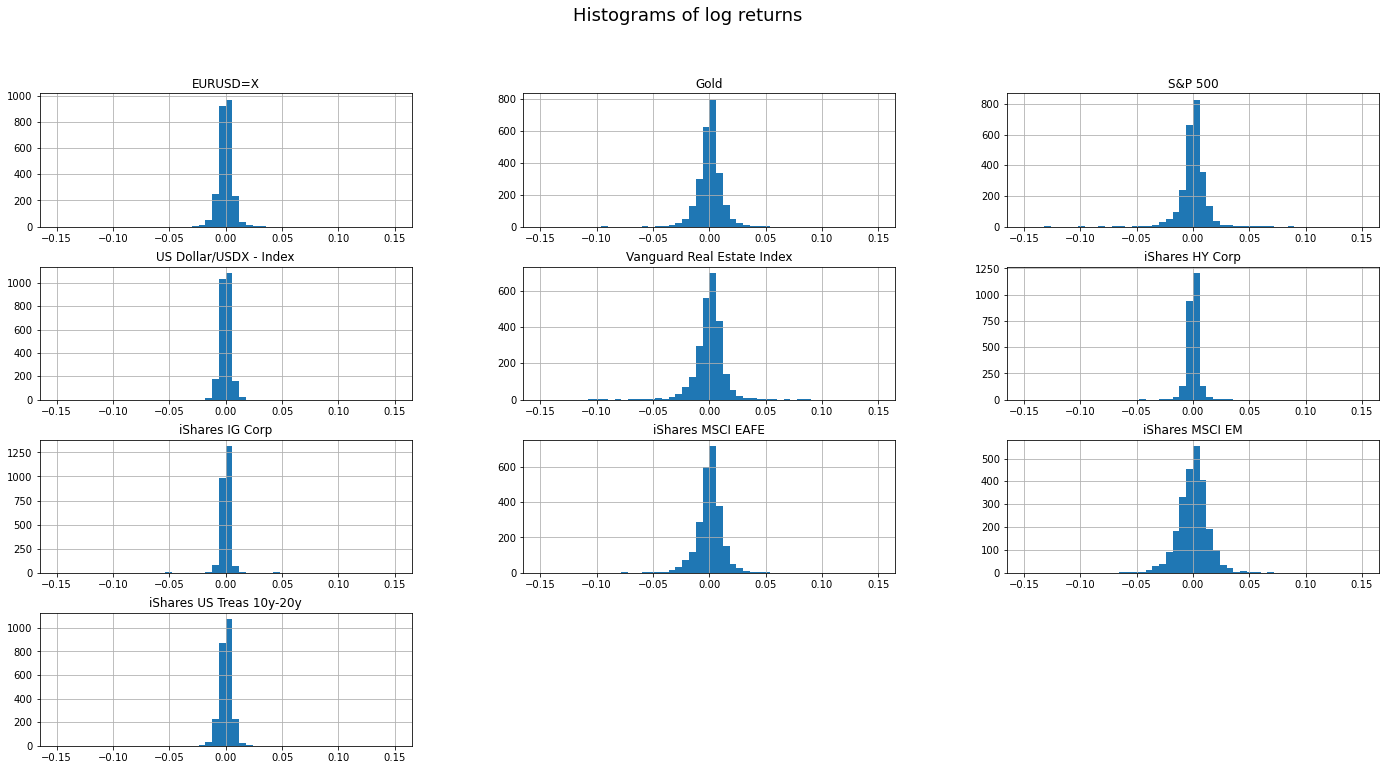

In [12]:
log_returns.hist(bins=50, figsize = (24,12), range = (-0.15, 0.15))

plt.suptitle("Histograms of log returns", fontsize= 18) 
;

In [33]:
for ticker in tickers_labels:
    print("\nResults for symbol %s" % ticker)
    print(30 * "-")
    log_data = np.array(log_returns[ticker])
    f.print_statistics(log_data)


Results for symbol Gold
------------------------------
     statistic           value
------------------------------
          size      2490.00000
           min        -0.09260
           max         0.04830
          mean         0.00012
           std         0.01001
          skew        -0.59293
      kurtosis         6.00971

Results for symbol iShares US Treas 10y-20y
------------------------------
     statistic           value
------------------------------
          size      2490.00000
           min        -0.05280
           max         0.04990
          mean         0.00022
           std         0.00570
          skew        -0.19504
      kurtosis        10.98756

Results for symbol iShares IG Corp
------------------------------
     statistic           value
------------------------------
          size      2490.00000
           min        -0.05130
           max         0.07130
          mean         0.00022
           std         0.00459
          skew         0.3

 The kurtosis values seem to be especially far from normal for all four data sets. We can also perform some normality tests.

In [34]:
for ticker in tickers_labels:
    print("\nResults for symbol %s" % ticker)
    print(30 * "-")
    log_data = np.array(log_returns[ticker])
    f.normality_test(log_data)


Results for symbol Gold
------------------------------
Skew of data set         -0.593
Skew test p-value          0.000
Kurt of data set          6.010
Kurt test p-value          0.000
Norm test p-value          0.000

Results for symbol iShares US Treas 10y-20y
------------------------------
Skew of data set         -0.195
Skew test p-value          0.000
Kurt of data set         10.988
Kurt test p-value          0.000
Norm test p-value          0.000

Results for symbol iShares IG Corp
------------------------------
Skew of data set          0.347
Skew test p-value          0.000
Kurt of data set         55.279
Kurt test p-value          0.000
Norm test p-value          0.000

Results for symbol iShares HY Corp
------------------------------
Skew of data set         -0.265
Skew test p-value          0.000
Kurt of data set         23.949
Kurt test p-value          0.000
Norm test p-value          0.000

Results for symbol S&P 500
------------------------------
Skew of data set       

 The above tests have normality as null hypothesis. Thus, normality is rejected for all of our data sets.

We can also study normality by generating normal random variables with mean and standard deviation equal to those of our sample data and comparing the theoretical distribution with the observed one.

Let's perform that excercise for the iShares HY Corp serie, which has a mean of 0.0002 and a standard deviation of 0.00546.

In [35]:
mu, sigma = 0.0002, 0.00546

HYCorp_normal = np.random.normal(mu, sigma, 2490)

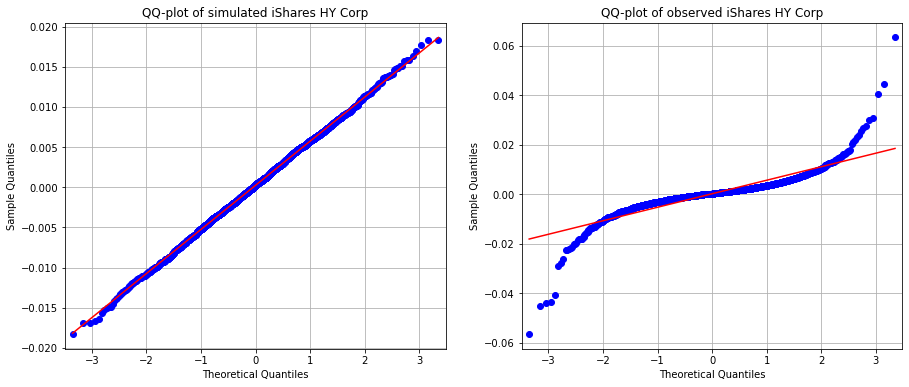

In [36]:
fig = plt.figure(figsize = (15,6))
ax = fig.add_subplot(1, 2, 1)

sm.qqplot(HYCorp_normal, line = 's', ax = ax)
plt.title('QQ-plot of simulated iShares HY Corp')
plt.grid(True)

ax = fig.add_subplot(1, 2, 2)
sm.qqplot(log_returns['iShares HY Corp'], line = 's', ax = ax)
plt.title('QQ-plot of observed iShares HY Corp')
plt.grid(True)

Text(0.5, 1.0, 'Histograms of simulated normal data and observed data')

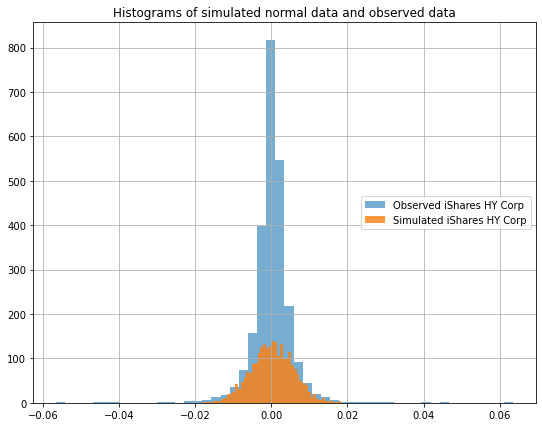

In [37]:
fig = plt.figure(figsize = (9,7))
plt.hist(log_returns['iShares HY Corp'], bins = 50,  label = 'Observed iShares HY Corp', alpha = 0.6)
plt.grid(True)
plt.hist(HYCorp_normal, bins = 50, label = 'Simulated iShares HY Corp', alpha = 0.8)
plt.grid(True)
plt.legend(loc = 'center right')
plt.title('Histograms of simulated normal data and observed data')

Even though normality does not hold, we will asume so in the rest of the analysis. Let's now generate the data we need.

In [6]:
noa = len(tickers_labels)
rets = np.log(data / data.shift(1)).dropna()
rets_mean= rets.mean() * 252
sigma = rets.cov() * 252

weights = f.rand_weights(noa)

In [13]:
weights = np.zeros((2000,noa))
for i in range(len(weights)):
    weights[i] = f.rand_weights(noa)
    
pret= f.portf_mean(weights, rets_mean)
pvol = np.sqrt(f.portf_var(weights, sigma))

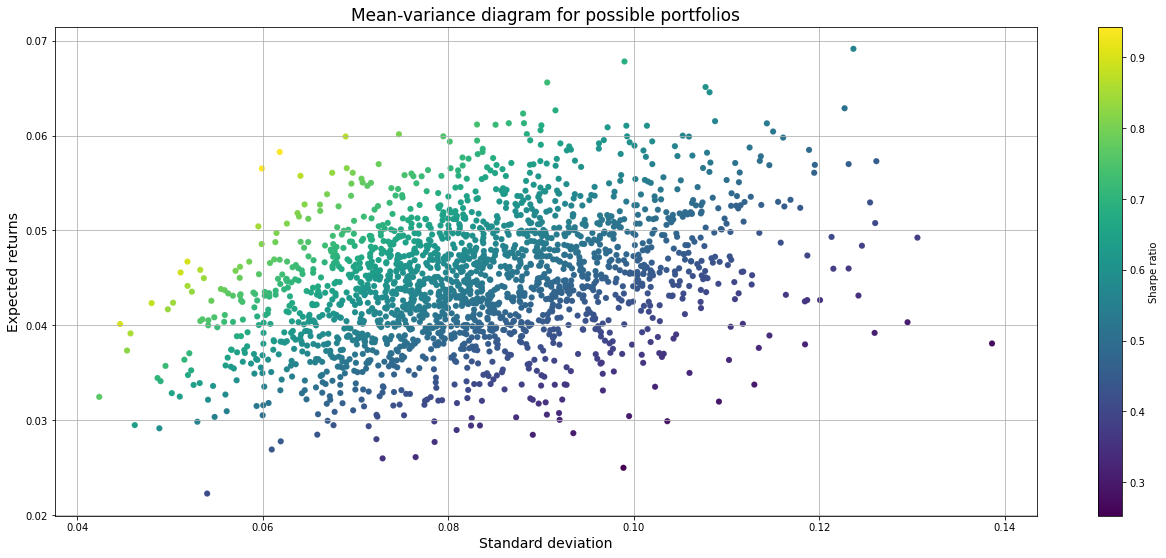

In [40]:
fig = plt.figure(figsize = (22,9))          
plt.scatter(pvol, pret, marker= 'o', lw = 0.1, c = pret/pvol)
plt.grid(True)
plt.title('Mean-variance diagram for possible portfolios', fontsize = 17)
plt.xlabel('Standard deviation', fontsize = 14)
plt.ylabel('Expected returns', fontsize = 14)
plt.colorbar(label = 'Sharpe ratio')

It is clear that not all weight distriburions perfom well when measured in terms of mean and variance. For example, for a fixed level of expected returns, say 0.04,  there are multiples portfolios that show different levels of risk. A rational investor would only be interested in the minimum risk given a fixed expected return, or the maximum return given a fixed risk level. This set of portfolios then makes up the so-called **efficient frontier**, which we will derive now.

## Portfolio Optimizations

To make our lives a bit easier, first we have a convenience function giving back the major portfolio statistics for an input weights vector/array.

The derivation of the optimal portfolios is a constrained optimization problem for which  we  use  the  function  minimize  from  the  scipy.optimize  sublibrary

In [3]:
def statistics(weights):
    
    weights = np.array(weights) 
    pret = np.sum(rets_mean * weights)
    pvol = np.sqrt(np.dot(weights.T, np.dot(sigma, weights)))
    
    return np.array([pret, pvol, pret / pvol])

The minimization function minimize is quite general and allows for (in)equality constraints and bounds for the parameters. Let us start with the maximization of the Sharpe ratio. Formally, we minimize the negative value of the Sharpe ratio:

In [42]:
def min_func_sharpe(weights):    
    return -statistics(weights)[2]

The constraint is that all parameters (weights) add up to 1. This can be formulated as follows using the conventions of the  minimize function

In [43]:
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

We also bound the parameter values (weights) to be within 0 and 1. These values are provided to the minimization function as a tuple of tuples in this case:

In [44]:
bnds = tuple((0, 1) for x in range(noa))

The only input that is missing for a call of the optimization function is a starting parameter list (initial guesses for the weights). We simply use an equal distribution.

Calling the function returns not only optimal parameter values, but much more. We store the results in an object we call opts.

In [45]:
opts = sco.minimize(min_func_sharpe, noa * [1. / noa], method='SLSQP',bounds=bnds, constraints=cons)
print(opts)

     fun: -1.3126308314800523
     jac: array([ 2.29534507e-03, -5.84766269e-04,  5.94024807e-02,  5.08859754e-04,
        3.12179327e-03,  9.40308660e-01,  2.12967889e+00,  1.28794621e+00,
       -1.80827081e-03,  3.33191082e-01])
 message: 'Optimization terminated successfully'
    nfev: 116
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([1.56724929e-02, 4.31844191e-01, 3.40651240e-15, 1.01689145e-01,
       1.98438634e-01, 0.00000000e+00, 2.39186180e-15, 7.29742601e-16,
       2.52355536e-01, 0.00000000e+00])


Our main interest lies in getting the optimal portfolio composition. To this end, we access the results object by providing the key of interest—i.e., x in our case. The optimization yields a portfolio that only consists of three out of the five assets:

In [46]:
print(tickers_labels)
opts['x'].round(3)

['Gold', 'iShares US Treas 10y-20y', 'iShares IG Corp', 'iShares HY Corp', 'S&P 500', 'iShares MSCI EAFE', 'iShares MSCI EM', 'Vanguard Real Estate Index', 'US Dollar/USDX - Index', 'EURUSD=X']


array([0.016, 0.432, 0.   , 0.102, 0.198, 0.   , 0.   , 0.   , 0.252,
       0.   ])

Using the portfolio weights from the optimization, the following statistics emerge:

In [47]:
statistics(opts['x']).round(3)

array([0.056, 0.043, 1.313])

Next, let us minimize the variance of the portfolio.

In [48]:
def min_func_variance(weights):    
    return statistics(weights)[1]**2

In [49]:
optv = sco.minimize(min_func_variance, noa * [1. / noa,],method='SLSQP', bounds=bnds,constraints=cons)
print(tickers_labels)
optv['x'].round(3)

['Gold', 'iShares US Treas 10y-20y', 'iShares IG Corp', 'iShares HY Corp', 'S&P 500', 'iShares MSCI EAFE', 'iShares MSCI EM', 'Vanguard Real Estate Index', 'US Dollar/USDX - Index', 'EURUSD=X']


array([0.066, 0.17 , 0.034, 0.133, 0.   , 0.062, 0.   , 0.   , 0.393,
       0.141])

We can further add two other possible portfolios: a risky one (Equity Mixed), and a more conservative one (Fixed Income Mixed)

In [50]:
print(tickers_labels)
w = np.array([0.00, 0.00, 0.00, 0.00, 0.34, 0.33, 0.33, 0.00, 0.00, 0.00])
w1 = np.array([0.00, 0.34, 0.33, 0.33, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00])
print(np.sum(w))
print(np.sum(w1))

ms_prets = np.sum(rets.mean() * w) * 252
ms_prets1 = np.sum(rets.mean() * w1) * 252

ms_vols = np.sqrt(np.dot(w.T, np.dot(rets.cov() * 252, w)))
ms_vols1 = np.sqrt(np.dot(w1.T, np.dot(rets.cov() * 252, w1)))

['Gold', 'iShares US Treas 10y-20y', 'iShares IG Corp', 'iShares HY Corp', 'S&P 500', 'iShares MSCI EAFE', 'iShares MSCI EM', 'Vanguard Real Estate Index', 'US Dollar/USDX - Index', 'EURUSD=X']
1.0
1.0


## Efficient frontier

The derivation of all optimal portfolios—i.e., all portfolios with minimum volatility for a given target return level (or all portfolios with maximum return for a given risk level)
—is similar to the previous optimizations. The only difference is that we have to iterate over multiple starting conditions. The approach we take is that we fix a target return
level and derive for each such level those portfolio weights that lead to the minimum volatility value. For the optimization, this leads to two conditions: one for the target
return level  tret and one for the sum of the portfolio weights as before. The boundary values for each parameter stay the same.

For clarity, we define a dedicated function min_func for use in the minimization procedure. It merely returns the volatility value from the  statistics function.

In [7]:
con1 = {'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret}
con2 = {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}
bnds = tuple((0, 1) for x in range(noa))

def min_func_port(w):
    return statistics(w)[1]

In [8]:
trets = np.linspace(0.0025, 0.105, 100)
tvols = []

ef_we = []

for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret}, {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',  bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
    ef_we.append(res['x'].round(3))
       
tvols = np.array(tvols)

ind = np.argmin(tvols)
tvols = tvols[ind:]
trets = trets[ind:]

In [9]:
ef_w = pd.DataFrame(ef_we,columns=tickers_labels)

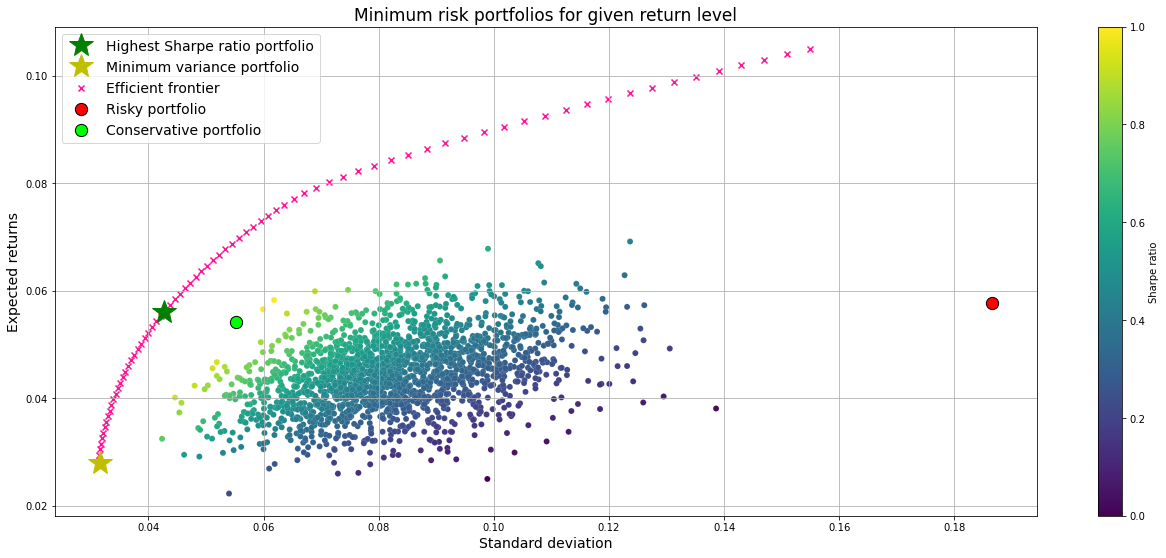

In [54]:
plt.figure(figsize=(22,9))

# random portfolio composition
plt.scatter(pvol, pret, marker= 'o', lw = 0.1, c = pret/pvol, edgecolors='w')

# efficient frontier
plt.scatter(tvols, trets, c = 'deeppink', marker='x', label='Efficient frontier', edgecolors='black')

# portfolio with highest Sharpe ratio

plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],'g*', markersize=25.0, label='Highest Sharpe ratio portfolio')

# minimum variance portfolio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],'y*', markersize=25.0, label='Minimum variance portfolio')


plt.scatter(ms_vols, ms_prets, c='red', s=150, marker='o',label='Risky portfolio', edgecolors='black')
plt.scatter(ms_vols1, ms_prets1, c='lime', s=150, marker='o',label='Conservative portfolio', edgecolors='black')

plt.grid(True)
plt.title('Minimum risk portfolios for given return level', fontsize = 17)
plt.xlabel('Standard deviation', fontsize = 14)
plt.ylabel('Expected returns', fontsize = 14)
plt.colorbar(label='Sharpe ratio')
plt.legend(fontsize=14, loc = 'best')

Note that the point cloud does not aproach much to the efficient frontier. That's because the optimal weights that generate the frontier are extreme weights, i.e. combination of only few assets. This is hardly randomly generated. Thus, we are gonna create those extreme weights in order to expand the point cloud.

In [10]:
def extreme_weights(noa):
    
    ew = f.rand_weights(noa)*np.random.randint(2, size=(noa))
    np.seterr(divide='ignore', invalid='ignore')
    return ew / sum(ew)

In [11]:
ex_weights = np.zeros((10000,noa))
for i in range(len(ex_weights)):
    ex_weights[i] = extreme_weights(noa)

In [14]:
new_weights = np.concatenate((weights, ex_weights, np.identity(noa), ef_we))

In [15]:
pret= f.portf_mean(new_weights, rets_mean)
pvol = np.sqrt(f.portf_var(new_weights, sigma))

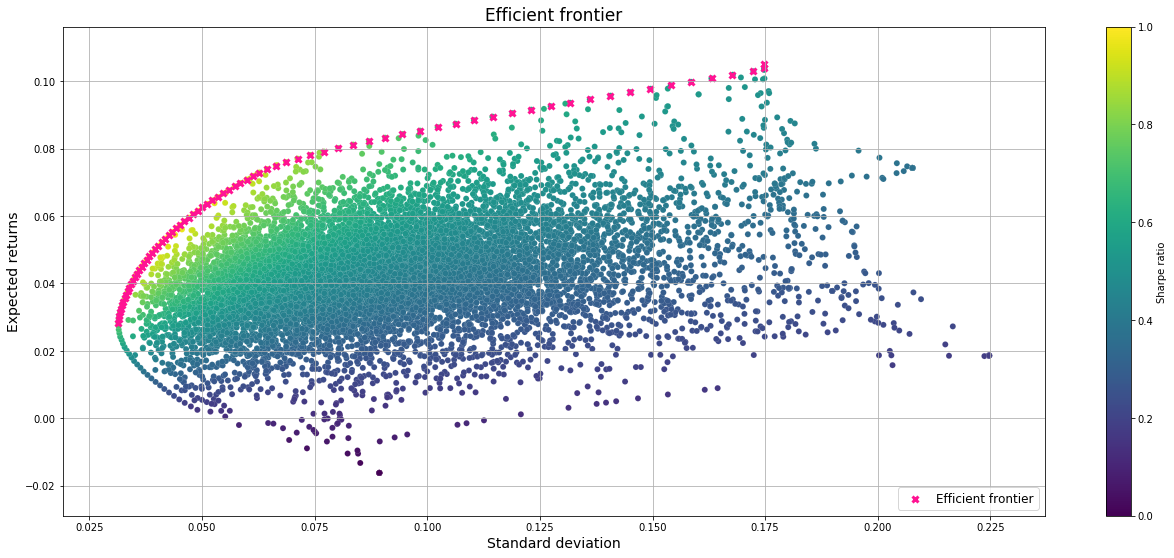

In [19]:
plt.figure(figsize=(22,9))

# random portfolio composition
plt.scatter(pvol, pret, marker= 'o', lw = 0.1, c = pret/pvol, edgecolors='w')

# efficient frontier
plt.scatter(tvols, trets, c = 'deeppink', marker='x', label='Efficient frontier', edgecolors='black')

# portfolio with highest Sharpe ratio

plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],'g*', markersize=25.0, label='Highest Sharpe ratio portfolio')

# minimum variance portfolio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],'y*', markersize=25.0, label='Minimum variance portfolio')


plt.scatter(ms_vols, ms_prets, c='red', s=150, marker='o',label='Risky portfolio (equity mixed)', edgecolors='black')
plt.scatter(ms_vols1, ms_prets1, c='lime', s=150, marker='o',label='Conservative portfolio (fixed income mixed)', edgecolors='black')

plt.grid(True)
plt.title('Minimum risk portfolios for given return level', fontsize = 17)
plt.xlabel('Standard deviation', fontsize = 14)
plt.ylabel('Expected returns', fontsize = 14)
plt.colorbar(label='Sharpe ratio')
plt.legend(fontsize=12, loc = 'lower right')

## Capital Market Line

In addition to risky securities like stocks or commodities (such as gold), there is in general one universal, riskless investment opportunity available: cash or cash accounts.
In an idealized world, money held in a cash account with a large bank can be considered riskless (e.g., through public deposit insurance schemes). The downside is that such a riskless investment generally yields only a small return, sometimes close to zero.

However, taking into account such a riskless asset enhances the efficient investment opportunity set for investors considerably. The basic idea is that investors first determine an efficient portfolio of risky assets and then add the riskless asset to the mix. By adjusting the proportion of the investor’s wealth to be invested in the riskless asset it is possible to achieve any risk-return profile that lies on the straight line (in the risk-return space) between the riskless asset and the efficient portfolio.

Let's now assume that the investors porfolio is formed with a proportion $p$ of risky assets which yields a return $R_x$ and $(1-p)$ of the riskless asset whose return $R_f$ is not a random variable. The new porfolio characteristics will then be:

$$ R_p = pR_x + (1 - p)R_f $$

$$ E(R_p) = p E(R_x) + (1-p)R_f = R_f + (E(R_x) - R_f)p$$

$$ \sigma^2_p = p^2\sigma^2_x$$

Thus the market line will be:

$$ E(R_p) = R_f +\dfrac{(E(R_x) -R_f)}{\sigma_p}\sigma_x$$
$$ E(R_p) = R_f +S_p \sigma_x$$

The investor may combine the risk-free asset with any portfolio of risky asset available, which gives rise to many straight lines in the mean-variance diagram. But among all the efficient portfolios, all investor will choose one that achieves the best mean-variance pair, that is the **tangency porfolio**. That portfolio is the one that maximizes the Sharpe Ratio.

In order to find the market line we need to carry a spline interpolation of the efficient frontier. The following code selects exactly these portfolios from our previously used sets tvols and trets.

In [21]:
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]

The new ndarray objects *evols* and *erets* are used for the interpolation:

In [22]:
tck = sci.splrep(evols, erets)

Via this numerical route we end up being able to define a continuos function f(x) for the efficient frontier:

In [23]:
def g(x):
    '''Efficient frontier function (splines approximation)'''
    return sci.splev(x, tck, der = 0)

In [24]:
Rf = 0.01

Sp = []
for sigma, mu in zip(evols, g(evols)):
     Sp.append((mu - Rf)/sigma)

In [25]:
sigma_T = np.linspace(0.0, 0.10)
E_T = Rf + max(Sp)*sigma_T

TP = np.argmax((g(evols)-Rf)/evols)

Text(0.5, 1.0, 'Capital market line and tangency portfolio')

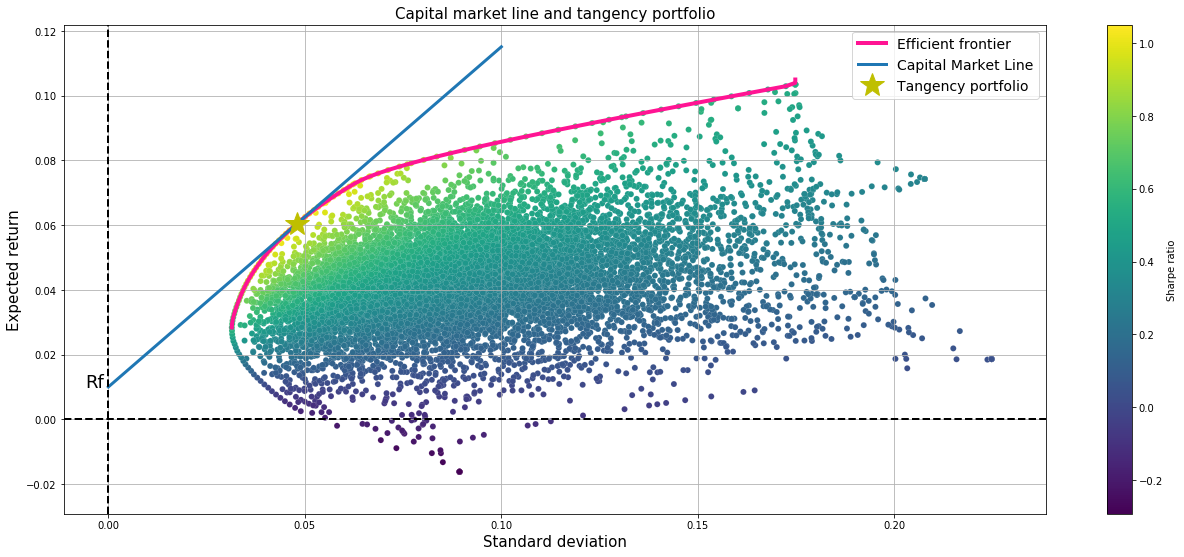

In [26]:
plt.figure(figsize=(22,9))

# random portfolio composition
plt.scatter(pvol, pret, marker= 'o', lw = 0.1, c = (pret-Rf)/pvol, edgecolors='w')

# efficient frontier
plt.plot(evols, erets, 'deeppink', lw=4, label='Efficient frontier')

# capital market line
plt.plot(sigma_T, E_T, lw = 3, label= 'Capital Market Line')

# tangency portfolio
plt.plot(evols[TP], erets[TP], 'y*', markersize=25.0, label='Tangency portfolio')

# risk free rate
plt.text(-0.006, Rf, 'Rf', fontsize = 18)

plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('Standard deviation', fontsize = 15)
plt.ylabel('Expected return', fontsize = 15)
plt.colorbar(label='Sharpe ratio')
plt.legend(fontsize=14)
plt.title('Capital market line and tangency portfolio', fontsize = 15)

The portfolio weights of the tangent portfolio are as follows. 

In [66]:
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - erets[TP]}, 
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',bounds=bnds, constraints=cons)

In [67]:
keys = tickers_labels
values = res['x'].round(4)
res = {keys[i]: values[i] for i in range(len(keys))} 
res

{'Gold': 0.0778,
 'iShares US Treas 10y-20y': 0.1156,
 'iShares IG Corp': 0.1176,
 'iShares HY Corp': 0.112,
 'S&P 500': 0.2032,
 'iShares MSCI EAFE': 0.0969,
 'iShares MSCI EM': 0.0593,
 'Vanguard Real Estate Index': 0.1569,
 'US Dollar/USDX - Index': 0.0602,
 'EURUSD=X': 0.0005}

# Risk measures

Consider three different type of assets, all with the same volatility and mean, but different distributions (e.g.: normal, uniform, Student-t). Standard mean variance analysis indicates that all three assets are qeually risky and preferable because their means and volatilities are the same. However, in reality, market participants view the risk in them quite differently and are likely to have a preference for one of these assets. This suggests that some objective way to comparethe risk in assets with different distribution is desirable.

Volatility or standard deviation is the main measure of risk in most financial analysis, but it is sufficient as a risk measure only when returns are normally distributed. However, as discused before, the normality assumption is violeted for most if not all financial returns. 


## Value-at-risk (VaR)

The most common reask measure after volatility is value-at-risk (VaR). It is a single summary statistical measure of risk, it is distribution independent and it is a measure of losses as a result of "typical" market movements.
VaR has become one of the most widely used risk measures, and a much debated one. Loved by practitioners for its intuitive appeal, it is also discussed and criticized by many - mainly on theoretical grounds, with regard to its limited ability to capture what is called *tail risk*.

***Definition***: *The loss on a trading portfolio such that there is a probability $p$ of losses equaling or exceeding VaR in a given trading period and a $(1-p)$ probability of losses being lower than the VaR.*

We may write it as $VaR(p)$ or $VaR$ at $100 \times  p \%$ to make the dependence on probability explicit. The most common probability levels are 1% or 5%.

VaR is a quantile of the distribution of profit and loss (P&L). We indicate P&L on an investment portfolio by the random variable $Q$, with a particular realization indicated by $q$. The density of P/L is denoted by $f_q (.)$. Thus, VaR is given by:

$$P[Q \leq -VaR(p)]= p$$

or

$$p = \int_{-\infty}^{-VaR(p)}f_q(x)dx$$

We use a minus sign because VaR is a positive number and we are dealing with losses. You should then interpret it as *the probability of losses being larger than VaR*.

Consider a stock position, worth 1 million USD today, that has a $VaR(0.01)$ (or $VaR$ at $1\%$) of 50,000 USD over a time period of 30 days (one month). This VaR figure says that the loss to be expected over a period of 30 days can exceed 50,000 USD with probability 0.01. In other words, there is a probability of 0.99 that losses will not exceed that value. 
However, it does not say anything about the size of the loss once a loss beyond 50,000 USD occurs—i.e., if the maximum loss is 100,000 or 500,000 USD what the probability of such a specific “higher than VaR loss” is. That is what is called the tail risk.


### Historical distribution 

The issue here is: what is the probability distibution of P&L of a portfolio? The above discussion was based on the assumption that that distribution was known. Howerever, in practice, one needs to estimate the P&L distribution using historical observations of the asset returns of interest. This historical simulation is a simple method for forecasting risk and relies on the assumption that history repeats itself, where one of the observed past returns is expected to be the next period return.

Let's take some of the fund returns we calculated above and calcule the VaR. 
Suppose we invest 10,000 for 30 days. We are interested in the VaR of a financial position in the S&P 500 and the iShares US Treas 10y-20y fund for 30 days.

In [36]:
initial_investment = 10000
investment_horizon = 30
SP500 = log_returns['S&P 500']
US_treas= log_returns['iShares US Treas 10y-20y']

In [37]:
SP500=(((SP500+1).rolling(investment_horizon).apply(np.prod)-1)*initial_investment).dropna()
US_treas=(((US_treas+1).rolling(investment_horizon).apply(np.prod)-1)*initial_investment).dropna()

In [80]:
def plot_var(portfolio):
    fig = plt.figure(figsize = (18,7))
    mask1 = portfolio<scs.scoreatpercentile(portfolio, 5)
    mask2 = portfolio>scs.scoreatpercentile(portfolio, 5)
    plt.hist(portfolio[mask2], bins = 60)
    plt.hist(portfolio[mask1], bins = 40, color='red')
    plt.xlabel('P&L')
    plt.ylabel('Frequency')
    plt.axvline(scs.scoreatpercentile(portfolio, 5), color='r', linestyle='dashed', linewidth=2, 
                label = 'VaR at 5% ='+ str(round(scs.scoreatpercentile(portfolio, 5),2)))
    plt.text(scs.scoreatpercentile(portfolio, 5)- np.std(portfolio), 35, 
             'p = 0.05', fontsize = 12)
    plt.title('Distribution of '+ portfolio.name)
    plt.grid(True)
    plt.legend(loc='best')
    ;
    return

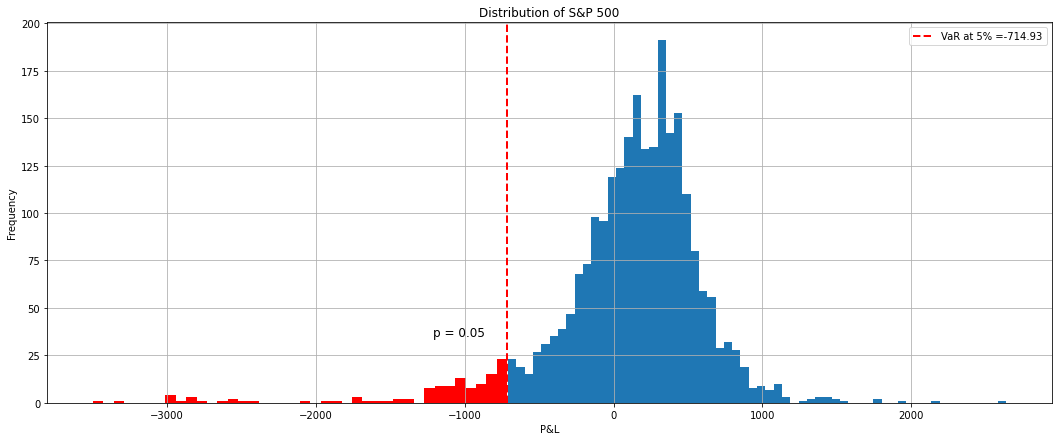

In [81]:
plot_var(SP500)

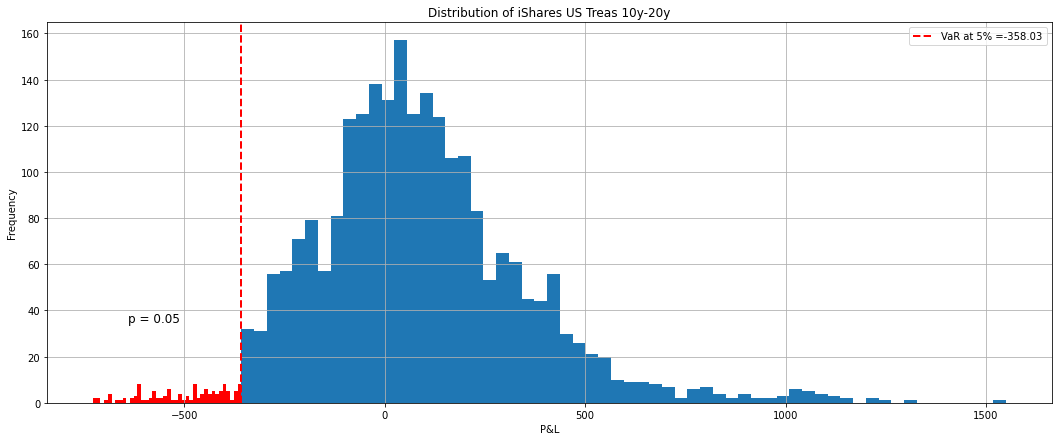

In [82]:
plot_var(US_treas)

In [83]:
def value_at_risk(portfolio):
    
    percs = [0.01, 0.1, 1., 2.5, 5.0, 10.0]
    VaR = scs.scoreatpercentile(portfolio, percs)
    print("%16s %16s" % ('Confidence Level', 'Value-at-Risk'))
    print(33 * "-")
    for pair in zip(percs, VaR):
        print("%11.2f %17.3f" % (100-pair[0], -pair[1]))
    return

In [84]:
value_at_risk(SP500)

Confidence Level    Value-at-Risk
---------------------------------
      99.99          3458.562
      99.90          3001.996
      99.00          1470.455
      97.50          1021.824
      95.00           714.932
      90.00           416.233


In [43]:
value_at_risk(US_treas)

Confidence Level    Value-at-Risk
---------------------------------
      99.99           726.102
      99.90           718.043
      99.00           608.110
      97.50           473.218
      95.00           358.035
      90.00           260.769


In [44]:
percs = list(np.arange(0.0, 10.1, 0.1))
SP500_var = scs.scoreatpercentile(SP500, percs)
US_treas_var = scs.scoreatpercentile(US_treas, percs)

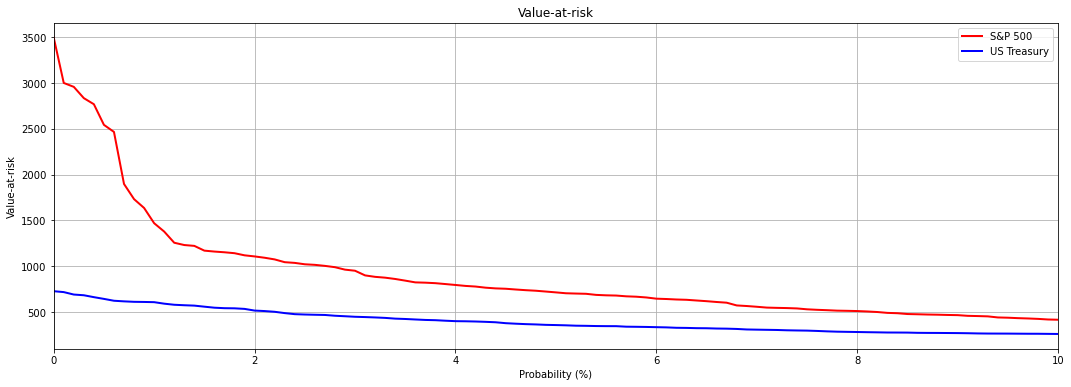

In [46]:
fig = plt.figure(figsize = (18,6))
plt.plot(percs, -SP500_var, lw=2, label='S&P 500', c='r')
plt.plot(percs, -US_treas_var, lw=2, label='US Treasury', c='b')
plt.legend(loc='best')
plt.xlabel('Probability (%)')
plt.ylabel('Value-at-risk')
plt.title('Value-at-risk')
plt.grid(True)
plt.autoscale(enable=True, axis='x', tight=True)

For each $p$, VaR of the S&P is always higher than VaR of US Treasuries.

### Monte Carlo simulations

Given the limitations of the above methods, a good replacement for VaR analysis is to perform Monte Carlo (MC) simulations.
The idea behind MC simulation is that we replicate market outcomes on the computer, based on some model of the evolution of the market. By doing a sufficient number of simulations, we get a large sample of market outcomes enabling us to calculate accurately some quantities of interests (VaR in this case). The main limitation of this approach is that it is always based on some model and the quality of the results in inevitably limited by the quality of the model.

For ilustration purpose, let's generate 3 different returns distributions and see how VaR behaves for each. The first two -standard normal and Student-t - are the most common one for replicating returns whereas the third one -uniform distributed- is an unusual case.

In [47]:
# Standard Normal
norm = np.random.standard_normal(10000)

# Student t
t = np.random.standard_t(5,10000)

#Uniform
unif = np.random.uniform(-1,1,10000)

NameError: name 'text' is not defined

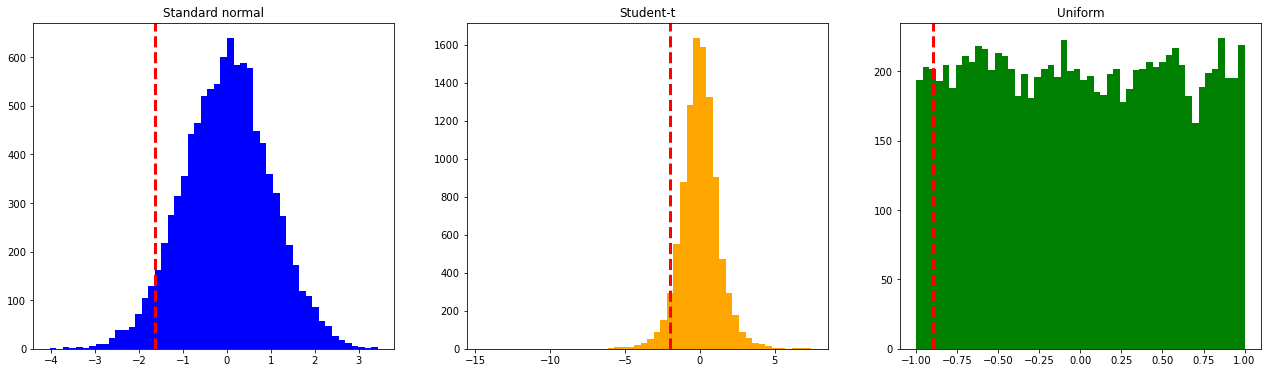

In [86]:
fig = plt.figure(figsize = (22,6))
plt.subplot(1,3,1)
plt.hist(norm, color = 'blue', bins = 50)
plt.title('Standard normal')
plt.axvline(scs.scoreatpercentile(norm, 5), color='r', linestyle='dashed', linewidth=3)

plt.subplot(1,3,2)
plt.hist(t, color = 'orange', bins = 50)
plt.title('Student-t')
plt.axvline(scs.scoreatpercentile(t, 5), color='r', linestyle='dashed', linewidth=3)

plt.subplot(1,3,3)
plt.hist(unif, color = 'green', bins = 50)
plt.title('Uniform')
plt.axvline(scs.scoreatpercentile(unif, 5), color='r', linestyle='dashed', linewidth=3)
text.usetex(True) 
;

Let's now generate daily returns of 3 assets to create a portfolio. 

We will asume Stundent-t distribution with different degrees of freedom (df). As the degrees of freedom increase, fewer extreme observations are obtained.
If df $\rightarrow \infty$, Student-t $\rightarrow$ Normal.
 
We will set equal weights for each asset.

In [49]:
rets1 = np.random.standard_t(5,10000)/100
rets2 = np.random.standard_t(50,10000)/100
rets3 = np.random.standard_t(100,10000)/100
rets = [rets1, rets2, rets3]

weights = [1/3, 1/3, 1/3]

In [50]:
port_rets = np.dot(weights, rets)
port_rets = pd.Series(port_rets, name ='simulated portfolio')

Let's again assume an initial investment of 10,000 and an investment horizon of 30 days.

In [51]:
initial_investment = 10000
investment_horizon = 30
port_rets =(((port_rets +1).rolling(investment_horizon).apply(np.prod)-1)*initial_investment).dropna()

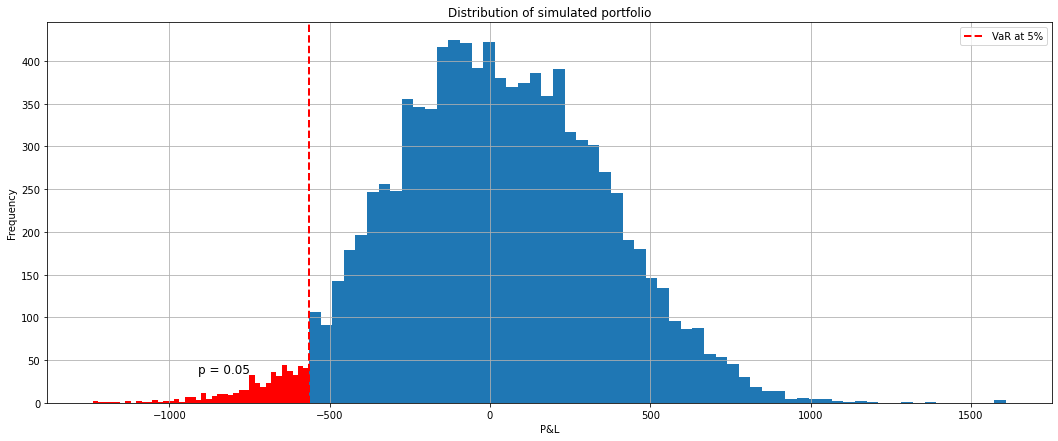

In [74]:
plot_var(port_rets)

In [53]:
value_at_risk(port_rets)

Confidence Level    Value-at-Risk
---------------------------------
      99.99          1237.912
      99.90          1083.341
      99.00           796.194
      97.50           674.268
      95.00           564.929
      90.00           422.397


## Expected shortfall

One of the flaws of the VaR aproach is that it is simply a quantile. In practice, the actual loss, if it occurs, can be grater than Var. In this sense, VaR may understimate the actual loss.
The most common alternative risk measure that tries to fill that gap is **expected shortfall** (ES), also known as tail VaR, conditional Value at Risk (CVaR), among others. ES answers the question: *what is expected loss when losses exceed VaR?*

*Definition*: Expected loss conditional on VaR being violated. $ES = -E[Q|Q\leq-VaR(p)]$

Let's define a function for ES and add it to our previous plots.

In [20]:
def ES(portfolio):
    var = scs.scoreatpercentile(portfolio, 5)
    shortfall = portfolio[portfolio<var]
        
    return shortfall.mean()

In [78]:
def plot_var_ES(portfolio):
    fig = plt.figure(figsize = (18,7))
    mask1 = portfolio<scs.scoreatpercentile(portfolio, 5)
    mask2 = portfolio>scs.scoreatpercentile(portfolio, 5)
    plt.hist(portfolio[mask2], bins = 60)
    plt.hist(portfolio[mask1], bins = 40, color='red')
    plt.xlabel('P&L')
    plt.ylabel('Frequency')
    plt.axvline(scs.scoreatpercentile(portfolio, 5), color='r', linestyle='dashed', linewidth=2, 
                label = 'VaR at 5% ='+ str(round(scs.scoreatpercentile(portfolio, 5),2)))
    plt.title('Distribution of '+ portfolio.name)
    plt.grid(True)
    plt.axvline(ES(portfolio), color='green', linestyle='dashed', linewidth=2, 
                label = 'Expected shortfall = '+str(round(ES(portfolio),2)))
    plt.legend(loc='best', fontsize = 12)
    ;
    return

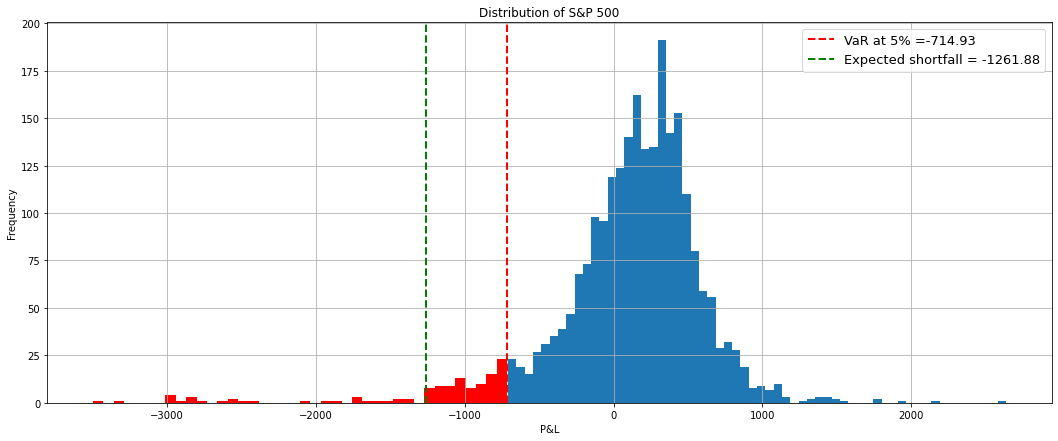

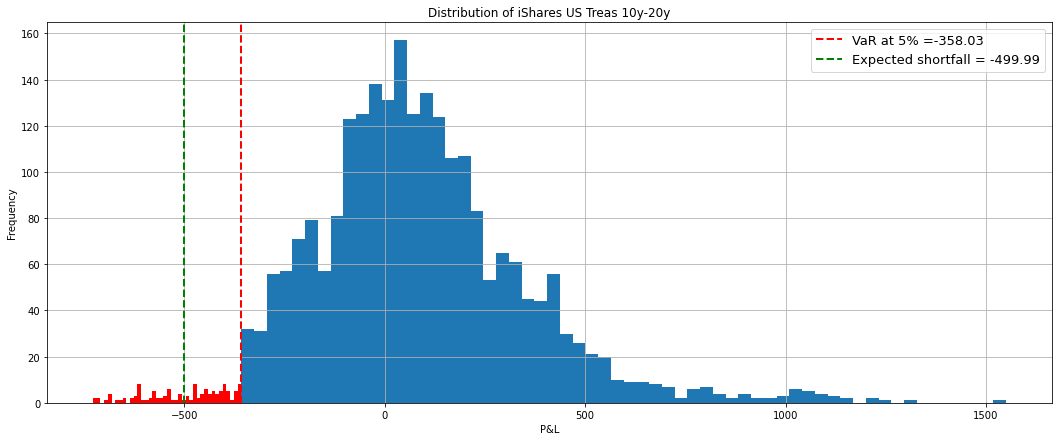

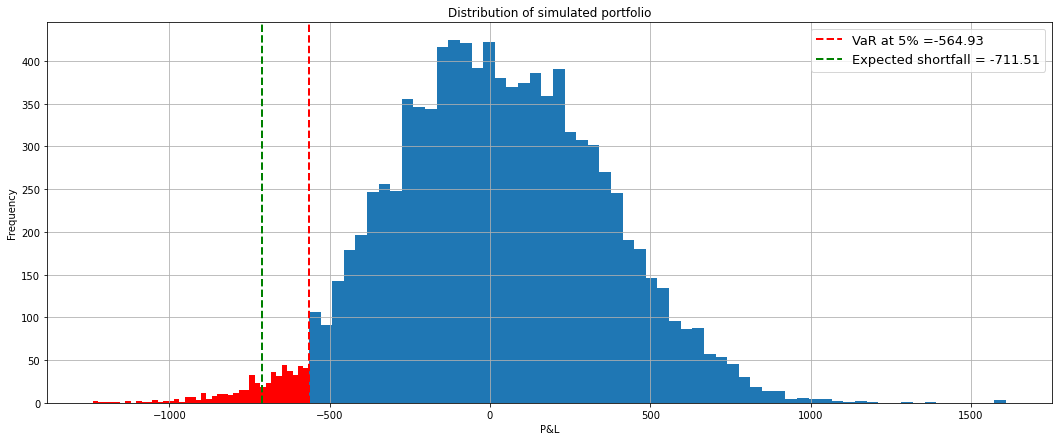

In [79]:
plot_var_ES(SP500)
plot_var_ES(US_treas)
plot_var_ES(port_rets)